# Satellite imagery analysis - Filtering and Object Detection

In this notebook I will filter the clips of the Port of Los Angeles that have been downloaded from the Planet servers based on how much of the port is actually visible. We will see that many of the clips only have the Port partially visible. This is not good enough if we want to count the number of ships on any given day at that point in time - the area that is measured should stay the same.

Therefore, the first step is to import the images:

In [68]:
# Import the modules needed in this Notebook
import os
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import numpy as np
import rasterio
import copy

%matplotlib inline

In [2]:
# List of all files in the images folder
path = '..//..//..//Prep_Analysis//images//'
allfiles = os.listdir(path)

In [3]:
# Find only the .tif (GeoTif) files
tif_files = [file for file in allfiles if file.endswith('.tif')]

In [4]:
print('The number of .tif files in /images is: '+str(len(tif_files))) 

The number of .tif files in /images is: 120


We will open up a few images to see what they look like

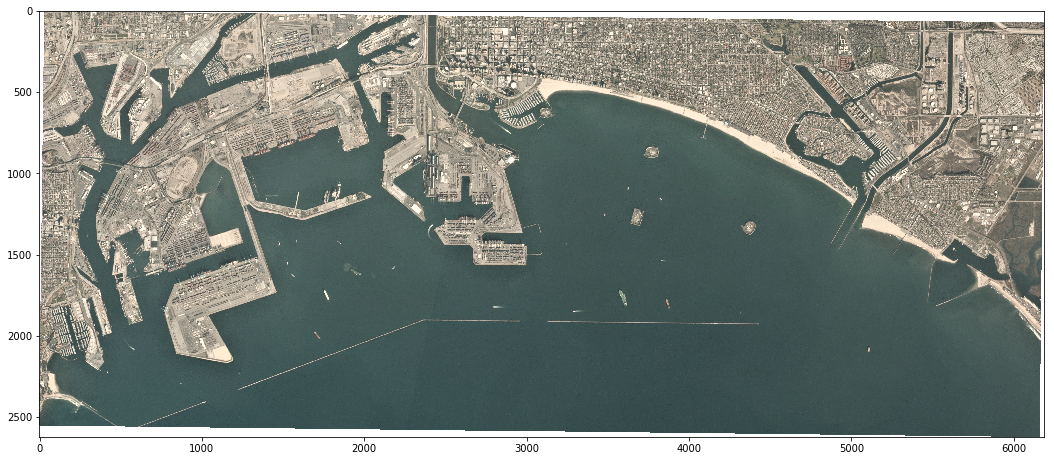

In [45]:
# Open and read the .tif file
img1 = rasterio.open(path+tif_files[0]).read()

# Display the image:
plt.figure(figsize = (18,36))
plt.imshow(np.dstack(img1))
plt.show()

In [6]:
# Find the non-zero pixel values in the first row of the first color (red)
non_zero = [(i,j) for i,j in enumerate(img1[0][0]) if j!=0]

In [7]:
non_zero

[(32, 226),
 (33, 222),
 (34, 212),
 (35, 202),
 (36, 193),
 (37, 180),
 (38, 186),
 (39, 195),
 (40, 249),
 (41, 255),
 (42, 255),
 (43, 255),
 (44, 255),
 (45, 255),
 (46, 255),
 (47, 255),
 (48, 255),
 (49, 255),
 (50, 255),
 (51, 255),
 (52, 250),
 (53, 229),
 (54, 203),
 (55, 182),
 (56, 190),
 (57, 189),
 (58, 219),
 (59, 239),
 (60, 232),
 (61, 193),
 (62, 186),
 (63, 175),
 (64, 170),
 (65, 170),
 (66, 160),
 (67, 158),
 (68, 171),
 (69, 177),
 (70, 181),
 (71, 145),
 (72, 111),
 (73, 95),
 (74, 101),
 (75, 109),
 (76, 97),
 (77, 93),
 (78, 101),
 (79, 119),
 (80, 122),
 (81, 125),
 (82, 140),
 (83, 152),
 (84, 143),
 (85, 128),
 (86, 130),
 (87, 135),
 (88, 150),
 (89, 154),
 (90, 169),
 (91, 188),
 (92, 194),
 (93, 202),
 (94, 201),
 (95, 190),
 (96, 174),
 (97, 172),
 (98, 169),
 (99, 164),
 (100, 172),
 (101, 188),
 (102, 204),
 (103, 203),
 (104, 205),
 (105, 205),
 (106, 206),
 (107, 202)]

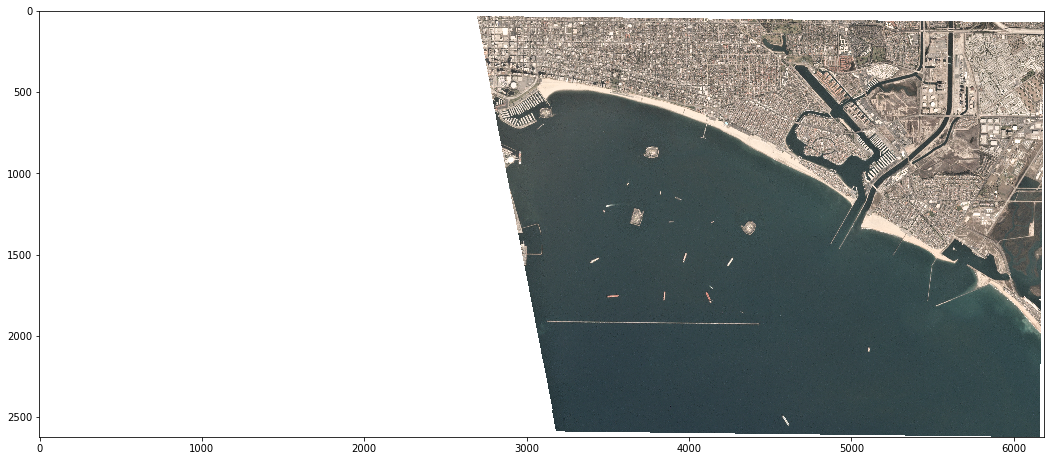

In [8]:
# We can see that from pixel 32 to 107, we have red intensities of varying amounts but nonzero.
# Let's look at another image:

# Open and read the .tif file
img2 = rasterio.open(path+tif_files[3]).read()

# Display the image:
plt.figure(figsize = (18,36))
plt.imshow(np.dstack(img2))
plt.show()

In [9]:
# Running the same code for finding non-zero values:
# Find the non-zero pixel values in the first row of the first color (red)
non_zero2 = [(i,j) for i,j in enumerate(img2[0][0]) if j!=0]

In [10]:
non_zero2

[]

In [11]:
# As would be assumed. Now if we go down to row 500:
non_zero500 = [(i,j) for i,j in enumerate(img2[0][500]) if j!=0]

In [12]:
# Display first ten
non_zero500[0:10]

[(2784, 243),
 (2785, 240),
 (2786, 240),
 (2787, 240),
 (2788, 240),
 (2789, 242),
 (2790, 242),
 (2791, 241),
 (2792, 235),
 (2793, 228)]

In [13]:
# After column 2784 we get non-zero values.

In [14]:
# Saving the red, green and blue arrays 
r = img1[0]
g = img1[1]
b = img1[2]

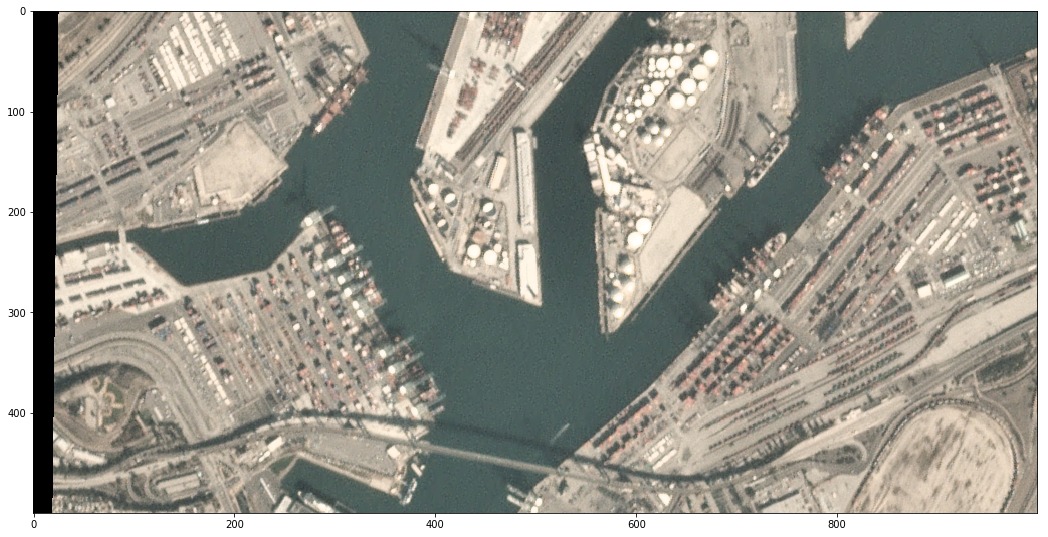

In [15]:
# Zoom in on a segement of the first image:
%matplotlib inline
plt.figure(figsize = (18,36))
plt.imshow(np.dstack([r[500:1000,0:1000],g[500:1000,0:1000],b[500:1000,0:1000]]))
plt.show()

In the above image we see there are a few container ships docked at the port either receiving or unloading cargo. We would like to ensure that all images in our list have these ports present in them. Therefore we will begin a list of necessary pixels

<IPython.core.display.Javascript object>


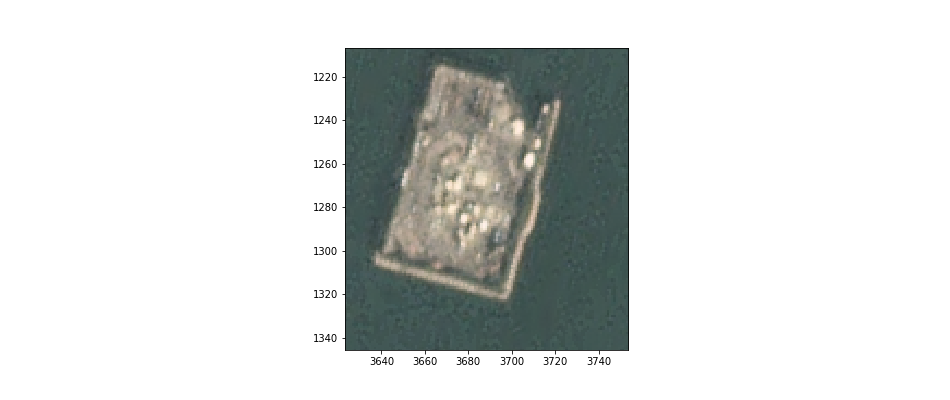

In [23]:
%matplotlib notebook
# Display the image:
#plt.figure(figsize = (18,36))
plt.imshow(np.dstack([r,g,b]))
plt.show()

In [17]:
# Based on zooming in to areas of interest we have the following x,y coordinates for the ports:
# Format: [(xmin,xmax),(ymin,ymax)]
port_coords = [[(270,335),(550,630)],
               [(275,420),(700,925)],
               [(400,480),(375,575)],
               [(670,855),(590,800)],
               [(360,420),(1110,1210)],
               [(790,910),(1550,1610)],
               [(960,1060),(1590,1640)],
               [(1440,1580),(280,340)],
               [(2130,2190),(630,780)],
               [(2740,2870),(1400,1450)]]

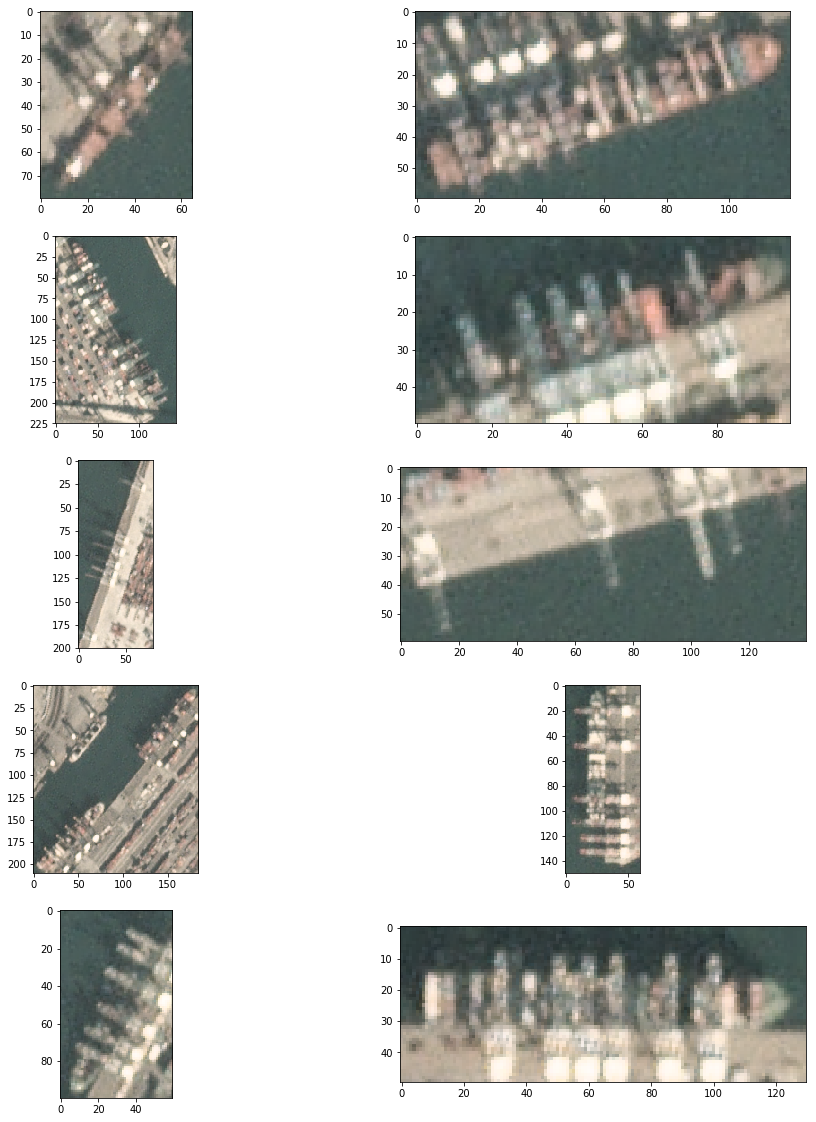

In [39]:
# The list above is not an exhaustive list of port entry points for the container ships, 
# but will be a starting point to filter out the images

# First double check that the areas selected are indeed ports:
%matplotlib inline

def plot_ports(coords_list,img):
    r,g,b,mask = img
    fig, axes = plt.subplots(5, 2)
    fig.set_figheight(20)
    fig.set_figwidth(16)
    for i,coords in enumerate(coords_list):
        (xmin,xmax),(ymin,ymax) = coords
        if i<5:
            axes[i,0].imshow(np.dstack([r[ymin:ymax,xmin:xmax],
                                        g[ymin:ymax,xmin:xmax],
                                        b[ymin:ymax,xmin:xmax]]))
        else:
            axes[i-5,1].imshow(np.dstack([r[ymin:ymax,xmin:xmax],
                                        g[ymin:ymax,xmin:xmax],
                                        b[ymin:ymax,xmin:xmax]]))        
        #plt.show()
    plt.show()
    
plot_ports(port_coords,img1)

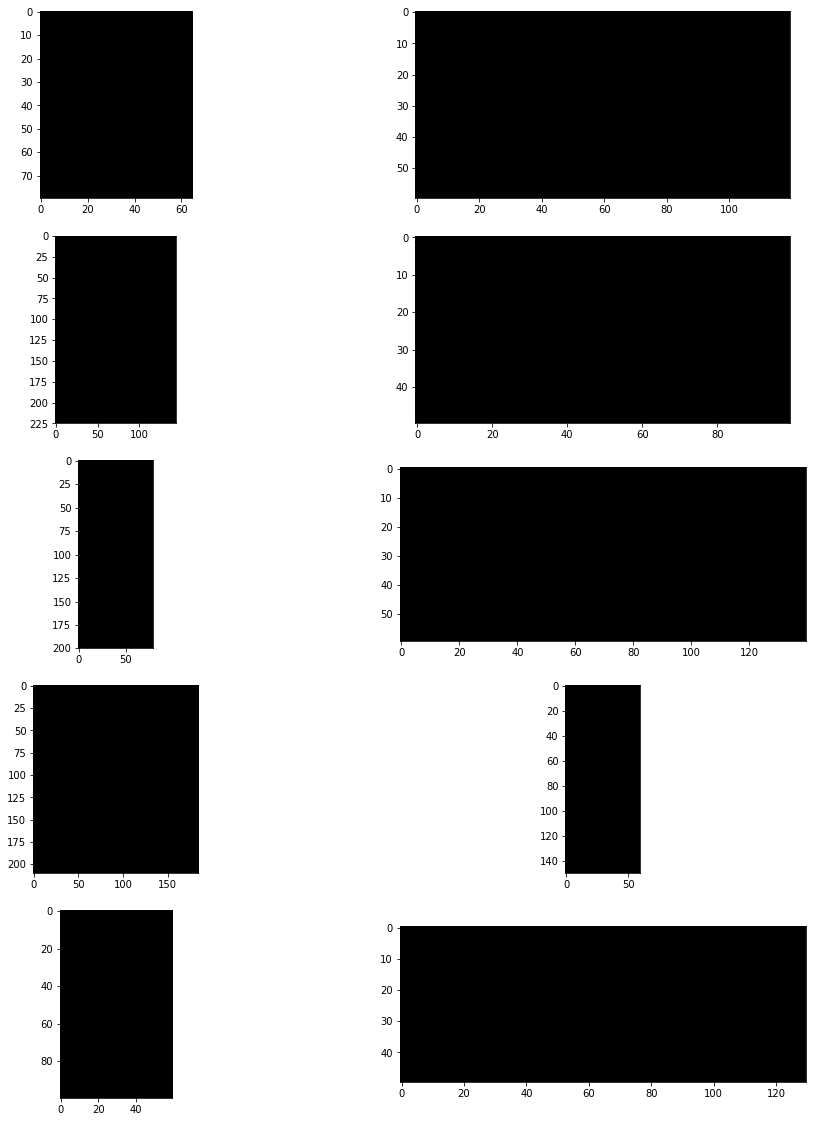

In [40]:
# Check if the coordinates of a port have non-zero values in the layers of the other image:
plot_ports(port_coords,img2)

In [34]:
# ALl the port outputs are blank, as expected. Let's look at one of the arrays:
xlim = (2740,2870)
ylim = (1400,1450)
img2[0][ylim[0]:ylim[1],xlim[0]:xlim[1]]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [35]:
# Count the number of non-zero elements:
np.count_nonzero(img2[0][ylim[0]:ylim[1],xlim[0]:xlim[1]])

0

In [57]:
# Therefore one way to check if the port image is blank is to check if there are no non-zero elements
zero_port_tifs = []

for i,filename in enumerate(tif_files):
    with rasterio.open(path+filename) as f:
        img = f.read()
        for coords in port_coords:
            (xmin,xmax),(ymin,ymax) = coords
            if np.count_nonzero(img[0][ymin:ymax,xmin:xmax]) == 0:
                zero_port_tifs.append(filename)
                break
        print('Read file '+str(i+1)+' of '+ str(len(tif_files)))

Read file 0 of 120
Read file 1 of 120
Read file 2 of 120
Read file 3 of 120
Read file 4 of 120
Read file 5 of 120
Read file 6 of 120
Read file 7 of 120
Read file 8 of 120
Read file 9 of 120
Read file 10 of 120
Read file 11 of 120
Read file 12 of 120
Read file 13 of 120
Read file 14 of 120
Read file 15 of 120
Read file 16 of 120
Read file 17 of 120
Read file 18 of 120
Read file 19 of 120
Read file 20 of 120
Read file 21 of 120
Read file 22 of 120
Read file 23 of 120
Read file 24 of 120
Read file 25 of 120
Read file 26 of 120
Read file 27 of 120
Read file 28 of 120
Read file 29 of 120
Read file 30 of 120
Read file 31 of 120
Read file 32 of 120
Read file 33 of 120
Read file 34 of 120
Read file 35 of 120
Read file 36 of 120
Read file 37 of 120
Read file 38 of 120
Read file 39 of 120
Read file 40 of 120
Read file 41 of 120
Read file 42 of 120
Read file 43 of 120
Read file 44 of 120
Read file 45 of 120
Read file 46 of 120
Read file 47 of 120
Read file 48 of 120
Read file 49 of 120
Read file 

In [70]:
port_vis_tifs = [item for item in tif_files if item not in zero_port_tifs]

In [72]:
port_vis_tifs

['1102960_1154610_2018-01-23_1002_RGB_Visual_clip.tif',
 '1107929_1154610_2018-01-24_1031_RGB_Visual_clip.tif',
 '1132838_1154610_2018-02-01_0c37_RGB_Visual_clip.tif',
 '1195425_1154610_2018-02-20_0f34_RGB_Visual_clip.tif',
 '1205482_1154610_2018-02-23_1039_RGB_Visual_clip.tif',
 '1221956_1154610_2018-02-28_1027_RGB_Visual_clip.tif',
 '1274206_1154610_2018-03-19_0f42_RGB_Visual_clip.tif',
 '1287446_1154610_2018-03-23_103d_RGB_Visual_clip.tif',
 '1305934_1154610_2018-03-27_0f43_RGB_Visual_clip.tif',
 '1339818_1154610_2018-04-09_103b_RGB_Visual_clip.tif',
 '1344624_1154610_2018-04-11_102c_RGB_Visual_clip.tif',
 '1347039_1154610_2018-04-12_1012_RGB_Visual_clip.tif',
 '1381794_1154610_2018-04-26_103a_RGB_Visual_clip.tif',
 '1406962_1154610_2018-05-05_0e16_RGB_Visual_clip.tif',
 '1416278_1154610_2018-05-10_1035_RGB_Visual_clip.tif',
 '1460857_1154610_2018-05-26_103a_RGB_Visual_clip.tif',
 '1471772_1154610_2018-06-01_100c_RGB_Visual_clip.tif',
 '1475332_1154610_2018-06-02_1020_RGB_Visual_cli

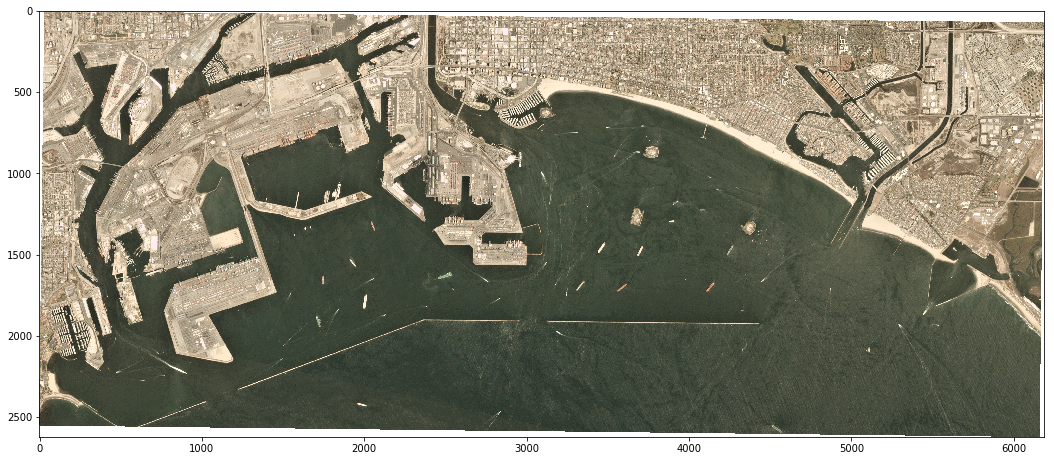

In [73]:
# Lets see what one of these looks like:

# Open and read the .tif file
img_vis = rasterio.open(path+port_vis_tifs[20]).read()

# Display the image:
plt.figure(figsize = (18,36))
plt.imshow(np.dstack(img_vis))
plt.show()

In [74]:
# Hazy but the full image is visible